# DeepShrooms

Our goal is to classify pictures of (common) mushrooms using some kind of web-app.

Challenge is to get good quality data for the training and then negate some common problems with images such as: lighting, angle, blurriness and background noise.

Current plan is to classify only the poisonous mushrooms of Finland along with some common edible and un-edible ones. Probably using Convolutional Neural Network.


Preliminary Models:

Mushroom Class
- name_fin - Finnish name
- name_eng - English name
- name_latin - Latin name
- url_mw - Mushroom-world url
- url_wiki? - Wikipedia url
- url_lajit? - Lajit.fi url
- img_urls? - List of links to its images. Probably should be deleted.
- edibility - edible/poisonous/inedible

Mushroom Image
- name_latin - Latin name
- name_img - Name of the image file
- img_url - URL to the original picture
- file_path - Path to the image from the root of its containing folder.

## Sources of data

Mushroom World
http://www.mushroom.world

Lajit
http://tun.fi/HBF.25786?locale=fi

Luontoportti
http://www.luontoportti.com/suomi/fi/sienet/


## General guidance for classifying mushrooms from pictures

1) Note where the mushroom grows: is it on the ground or on wood.  
1.1) If it grows on ground it could be a saprotroph of detritus (karikkeen lahottaja), mycorrhiza (juurisieni) which is specific type of mushroom living from the roots of a tree or it could still be a saprotroph of a tree but the wood is on ground level.  
1.2) If it grows on wood consider if it's conifer(havupuu) or hardwood(lehtipuu). Some species grow on only a very specific wood like oak.  
2) Do not consider the time of year to be a indicator of any sort. Every year the seasons length differ so one year the mushroom season might start way later than the next year.  
3) Underneath the mushroom cap can be different types of gills in various combinations. (TODO)  
4) Surface of the cap is also a very good classifier of the mushroom. The structure might not be possible to know from a picture though.  
5) Color of the mushroom varies a lot depending on the humidity and the age of the mushroom. When raining the colors get deeper and more distinctive. Young mushrooms have stronger colors than old ones. Also sunlight might diminish the colors.  
6) Stipe(jalka) of a mushroom can also indicate a lot of information from the mushroom. Thin and thick shapes are more distinctive than average size.  
7) Geographic location of the mushroom could be useful as some species probably don't grow everywhere in Finland.

There is also a lot of data such as smell and touch that could be used but then user would have to input it him or herself.

Sources:
* http://www.funga.fi/teema-aiheet/sienten-tunnistaminen/


# Downloading and importing the dataset

We scraped the data from mushroom.world website using a scraper beforehand. The images and the metadata are stored in both Google Drive and Amazon S3. But since Google Drive doesn't support direct downloads (like wtf) I had to put the file in S3 too. With public access rights, yey.

## About the pictures

The pictures are `.jpg` pictures resized to a standard 480x480 size. (Or 360x480?)

In [19]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

DATASET_VERSION = 'mushroom_world_2017_16_10'
DATASET_LINK = 'https://s3.eu-central-1.amazonaws.com/deep-shrooms/{}.zip'.format(DATASET_VERSION)

with urlopen(DATASET_LINK) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('./data')
        

In [20]:
import pandas as pd
import numpy as np

DATASET_PATH = 'data/{}/'.format(DATASET_VERSION)

mushroom_classes = pd.read_json(DATASET_PATH + 'mushroom_classes.json', lines=True)
mushroom_imgs = pd.read_json(DATASET_PATH + 'mushroom_imgs.json', lines=True)
fin_names = pd.read_csv('test_labels.csv')

In [21]:
mushroom_info = mushroom_imgs.merge(mushroom_classes, how = "right", on = "name_latin")
mushroom_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536 entries, 0 to 535
Data columns (total 8 columns):
file_path     536 non-null object
img_url       536 non-null object
name_img      536 non-null object
name_latin    536 non-null object
edibility     536 non-null object
img_urls      536 non-null object
name_eng      536 non-null object
url_mw        536 non-null object
dtypes: object(8)
memory usage: 37.7+ KB


In [22]:
from scipy import misc

def load_mushroom_images(folder_path, img_df):
    img_dict = {}
    for index, path in enumerate(img_df['file_path']):
        img_dict[index] = misc.imread(folder_path + path)
    return img_dict
        
img_dict = load_mushroom_images(DATASET_PATH, mushroom_info)

In [23]:
mushroom_info.iloc[0]

file_path                   mushroom_img/tylopilus_felleus0.jpg
img_url       http://www.mushroom.world/data/fungi/Tylopilus...
name_img                                 tylopilus_felleus0.jpg
name_latin                                    Tylopilus felleus
edibility                                              inedible
img_urls      [http://www.mushroom.world/data/fungi/Tylopilu...
name_eng                                          Bitter Bolete
url_mw        http://www.mushroom.world/show?n=Tylopilus-fel...
Name: 0, dtype: object

In [26]:
#Quick look at the amount and shapes of images are not in the shape of the first element, 
#which is in the most common format (360,480,3)
i = 0
for img in img_dict:
    if img_dict[img].shape != img_dict[0].shape:
        i = i + 1
        print(img_dict[img].shape)
        print(img)
print(i)

#If this cell is run after the formatting is done, it should print 0 since all pictures should be in same format

0


In [25]:
import math
#Format the pictures to (480,480,3) by padding them with the edge values
for img in img_dict:
    height = 480 - img_dict[img].shape[0]
    width = 480 - img_dict[img].shape[1]

    if(height % 2 == 1 & width % 2 == 1):
        height1,height2 = math.floor(height/2), math.floor(height/2) + 1
        width1,width2 = math.floor(width/2), math.floor(width/2) +1
    elif(width % 2 == 1):
        width1,width2 = math.floor(width/2), math.floor(height/2) + 1
        height1,height2 = int(height/2), int(height/2)
    elif(height % 2 == 1):
        height1,height2 = math.floor(height/2), math.floor(height/2) + 1
        width1,width2 = int(width/2), int(width/2) 
    else:
        height1,height2 = int(height/2), int(height/2)
        width1,width2 = int(width/2), int(width/2)

    if(height == 0):
        img_dict[img] = np.lib.pad(img_dict[img], ((0,0),(width1, width2),(0,0)), 'edge')
    elif (width == 0):
        img_dict[img] = np.lib.pad(img_dict[img], ((height1, height2),(0,0),(0,0)), 'edge')
    else:
        img_dict[img] = np.lib.pad(img_dict[img], ((height1, height2),(width1, width2),(0,0)), 'edge')

In [28]:
import matplotlib.pyplot as plt

def draw_im(i, image_data=img_dict, label_data=mushroom_info):
    name = label_data.iloc[i].name_latin
    edibility = label_data.iloc[i].edibility
    url = label_data.iloc[i].img_url
    x = image_data[i]
    plt.imshow(x)
    plt.title( name + ": " + edibility + "\n(" + url + ")")
    plt.show()


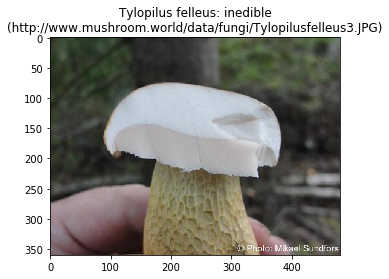

In [29]:
draw_im(2)

# Some formatting

Create a binary variable from the different edibility classes. One justifiable choice seems to be to categorize the mushrooms to only edible vs non-edible. The category "edible when cooked" can also be included in the non-edibles. Therefore any mushroom labeled with edible would be safe to eat without any concern.

In [30]:
mushroom_info.edibility.value_counts()

inedible                202
edible                  149
poisonous                77
edible and good          50
edible and excellent     27
lethally poisonous       16
edible when cooked       15
Name: edibility, dtype: int64

In [31]:
labels = mushroom_info.edibility.isin(("edible", "edible and good", "edible and excellent"))

# for testing, exclude arrays that are not of common shape
# most are 360x480x3, so keep those
X = []
y = []

for i in range(len(labels)):
    if(img_dict[i].shape == (360,480,3)):
        y.append(labels[i])
        X.append(img_dict[i])


X = np.stack(X)
y = pd.Series(y)

print(X.shape)
print(y.shape)

(370, 360, 480, 3)
(370,)


It is usually a good idea to at least standardice the predictors. Below I use imagedatagenerator from keras which can also provide augmentatio of the images. This can help to create more artificial data samples.

In [32]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X)


Our labels are now a binary variable where "True" indicates that the mushroom is edible.

In [33]:
y.value_counts()

False    199
True     171
dtype: int64

# Modeling

Use Keras to train neural networks. A tutorial for binary image classification is [here](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [34]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

def my_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=X[0].shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.add(Activation('sigmoid')) # sigmoid is the binary case of softmax 
    return model



In [35]:
model = my_model()
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [37]:
# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X, y, batch_size = 32),
                    steps_per_epoch=len(X) / 32, epochs = 1, verbose = 2)
model.save_weights('models/first_try.h5')

Epoch 1/1
127s - loss: 7.4396 - acc: 0.5384


In [20]:
model.predict(X[0:20])

array([[  1.78946545e-11],
       [  3.43246787e-09],
       [  1.67518665e-04],
       [  1.69859021e-07],
       [  5.52692503e-10],
       [  1.40266479e-10],
       [  5.66854874e-09],
       [  1.40513987e-06],
       [  1.41793599e-09],
       [  2.64992250e-09],
       [  5.93276610e-08],
       [  1.93343297e-09],
       [  1.04981371e-11],
       [  1.30468019e-04],
       [  9.88119731e-16],
       [  4.68935100e-18],
       [  2.42456852e-13],
       [  9.04552308e-16],
       [  2.13720643e-13],
       [  1.19405608e-09]], dtype=float32)